In [1]:
# Connect to the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append("/content/drive/MyDrive/Github/face-comic-recognizer/scr")

In [3]:
import tensorflow as tf
import numpy as np
import os 
import pathlib
from constants import IMG_HEIGHT,IMG_WIDTH, BATCH_SIZE, SEED
#import data_util
from data_util import *

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

# (0) Data loading

In [5]:
# Upload kaggle.json
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Kaggle"
# The dataset will be stored in Google Colab, not in Google Drive!
!pip install --upgrade kaggle
!kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2
!unzip \*.zip  
%rm *.zip
%rm -rf face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/samples

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 2.17G/2.18G [00:14<00:00, 239MB/s]
100% 2.18G/2.18G [00:14<00:00, 165MB/s]
Archive:  comic-faces-paired-synthetic-v2.zip
replace face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/samples/face2comics_v2.0.0_by_Sxela_preview_10x10x256.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/samples/face2comics_v2.0.0_by_Sxela_preview_2x2x512.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/samples/unet_sample_2x2.jpg  


In [5]:
data_dir = pathlib.Path("/content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela")
image_count = len(list(data_dir.glob('*/*.jpg')))

# (1) Data extraction

In [6]:
train_ds_paths, val_ds_paths, test_ds_paths = train_val_test_split(
    get_file_paths(folder_path=data_dir), 
    image_count,
    data_dir)

The train set: tf.Tensor(16000, shape=(), dtype=int64)
The validation set: tf.Tensor(2000, shape=(), dtype=int64)
The test set: tf.Tensor(2000, shape=(), dtype=int64)


In [29]:
print("Train")
get_class_proportions(train_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE), 16000)
print("Val")
get_class_proportions(val_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE), 2000)
print("Test")
get_class_proportions(test_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE), 16000)

Train
zero: 7981
one: 8019
Val
zero: 1018
one: 982
Test
zero: 1001
one: 999


In [7]:
# Create the color subsets from |the file paths
# (lambda x: fun(x, my_arg))
train_ds = prepare_for_training(train_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE))
val_ds = prepare_for_training(val_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE))
test_ds = prepare_for_training(test_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE))

In [8]:
# Create the grayscale subsets from the file paths
# (lambda x: fun(x, my_arg))
train_ds_gs = prepare_for_training(train_ds_paths.map(lambda x: process_path(x, data_dir, False), num_parallel_calls=AUTOTUNE))
val_ds_gs = prepare_for_training(val_ds_paths.map(lambda x: process_path(x, data_dir, False), num_parallel_calls=AUTOTUNE))
test_ds_gs = prepare_for_training(test_ds_paths.map(lambda x: process_path(x, data_dir, False), num_parallel_calls=AUTOTUNE))

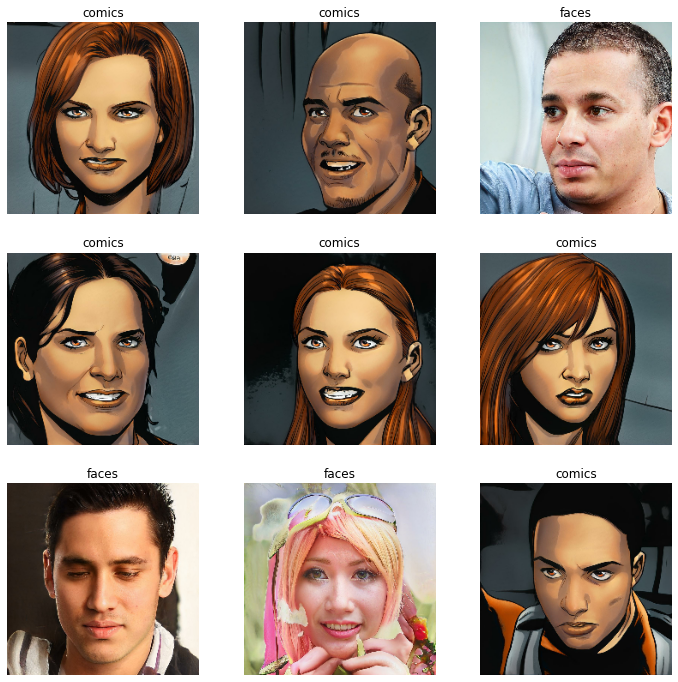

In [9]:
show_batch_examples(train_ds, data_dir)

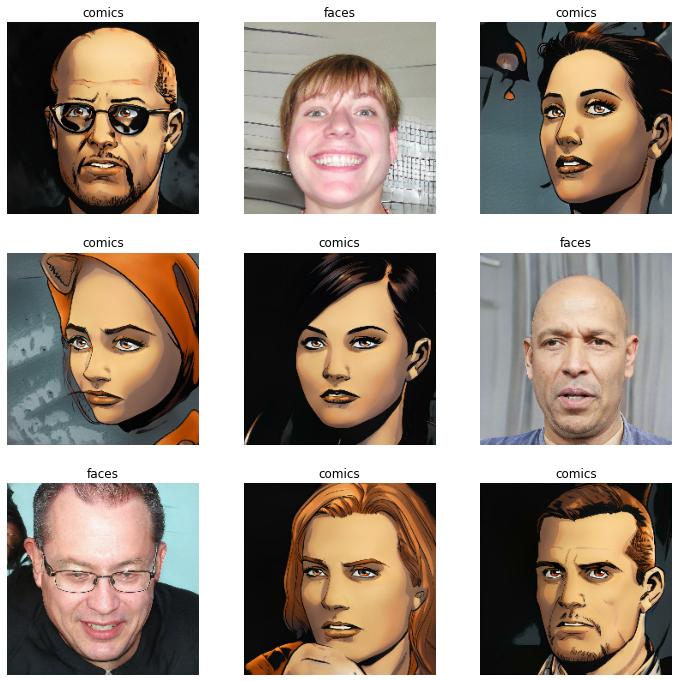

In [10]:
show_batch_examples(val_ds, data_dir)

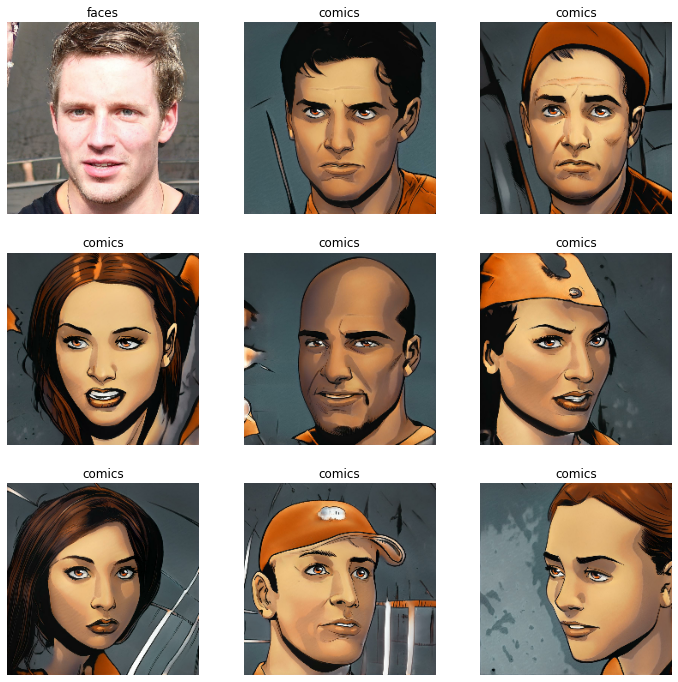

In [17]:
show_batch_examples(test_ds, data_dir)

In [19]:
def get_class_proportions2(dataset, num):
    zero, one = 0, 0
    for image, label in dataset.take(num):
        if label.numpy() == 0:
            zero += 1
        elif label.numpy() == 1:
            one += 1
    print("zero: " + str(zero))
    print("one: " + str(one))  

In [20]:
get_class_proportions2(train_ds_paths, 1000)

TypeError: ignored

In [24]:
for image, label in train_ds.take(2):
    print(label)

tf.Tensor([0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1], shape=(32,), dtype=int64)
tf.Tensor([1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0], shape=(32,), dtype=int64)
